In [1]:
import torchvision
import torch

import matplotlib.pyplot as plt
import os
import shutil
from sklearn.metrics.pairwise import rbf_kernel
from tools.models import DDPM, UNet
from tools.data_utils import *
from torchvision.io import read_image
from torchvision import datasets, transforms
from tqdm import tqdm
import csv

/home/ozcan.g/.conda/envs/satellite_gpu_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = 1000
d1 = 28
d2 = 28
seed = 123456
sigma = 10
np.random.seed(seed)

In [3]:
def del_and_create(folder_name):
    # delete the data folder if it already exists
    if os.path.exists(folder_name) and os.path.isdir(folder_name):
        shutil.rmtree(folder_name)
    
    # create a new data folder
    os.makedirs(f"{folder_name}")
    return

In [4]:
folder = "Synthetic"

root_folder = f"./data/{folder}/{d1}by{d2}pixels_{n}images_{seed}seed"   
image_folder = f"./data/{folder}/{d1}by{d2}pixels_{n}images_{seed}seed/images"

del_and_create(root_folder)
os.makedirs(image_folder)

In [5]:
def f(P1, P2, c):
        return c[0] * funcs[0](P1) ** c[1] + c[2] * funcs[1](c[3] + P2 * P1) * funcs[2](P1)

In [6]:
import warnings
warnings.filterwarnings("ignore")

images = []

for i in range(n):
    #these will generate the images
    c = np.random.randint(0, 10, size=4)
    func_list = [np.sin, np.cos]
    funcs = np.random.choice(func_list, 3)
    p1 = np.linspace(0, 5, d1)
    p2 = np.linspace(0, 5, d2)
    P1, P2 = np.meshgrid(p1, p2, indexing='ij')
    
    z = f(P1, P2, c)
    
    # indexing check
    # for i, vali in enumerate(p1):
    #     for j, valj in enumerate(p2):
    #         if z[i, j] != f(vali, valj):
    #             print("not equal!")
    
    fig = plt.figure(figsize=(7,7))
    plt.imshow(z, origin='lower')  # http://brantr.github.io/blog/matplotlib-imshow-orientation/
    plt.axis('off')
    
    img_name = f"{i}"
    fig.savefig(f'{image_folder}/{img_name}.png', bbox_inches='tight', pad_inches=0)
    image = read_image(f'{image_folder}/{img_name}.png')
    image = transforms.functional.resize(image, size=(28, 28))
        
    plt.close()
    
    images.append(image)

In [7]:
# mean and covariance functions
a = 3
b = 0.5 # smaller b - small bias

# nonlinear mean (quadratic)
def quad_mean(p_1, p_2, z):
    return a * z[(p_1, p_2)] ** 2 + b

# linear mean
def mean(p_1, p_2, z):
    return a * z[(p_1, p_2)] + b

# RBF kernel with a small width
gamma = (1 / (sigma ** 2))
def cov(p_1, p_2, gamma):
    """
        K(p_1, p_2) = exp(-gamma ||p_1-p_2||^2)
    """
    return rbf_kernel(p_1, p_2, gamma=gamma) # this should only depend on p1 and p2 - enforce continuity

In [8]:
def find_labels(pins):
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html
    # .reshape(-1) converts a 2D matrix to a 1D vector (e.g. 100x1 --> 1x100)
    mean_vec = mean(np.asarray(pins)[:, 1], np.asarray(pins)[:, 0], z)
    cov_mat = cov(np.asarray(pins)[:, 1], np.asarray(pins)[:, 0], gamma)
    min_eig = np.min(np.real(np.linalg.eigvals(cov_mat)))
    if min_eig < 0:
        cov_mat -= 10*min_eig * np.eye(*cov_mat.shape)
    return np.random.default_rng().multivariate_normal(mean_vec.reshape(-1), cov_mat)

In [9]:
header = ['image', 'pins', 'outputs']
def add_header(folder_name, header):
    with open(f"{folder_name}/pins.csv", 'w') as file:
        writer = csv.writer(file)
        writer.writerow(header)

In [10]:
def reformat(arr):
    return [(i[0][0], i[1][0]) for i in arr]

In [11]:
L = 10
step = 10

random_data_folder = f"./data/{folder}/{d1}by{d2}pixels_{n}images_{seed}seed/random_{L}pins/"
mesh_data_folder = f"./data/{folder}/{d1}by{d2}pixels_{n}images_{seed}seed/mesh_{step}step_pins/"

del_and_create(random_data_folder)
del_and_create(mesh_data_folder)

add_header(random_data_folder, header)
add_header(mesh_data_folder, header)

rand_pins = []
grid_pins = []
rand_labels = []
grid_labels = []

for i in range(n):

    # Generate a list of all possible (x, y) coordinates
    rand_p_1i = np.arange(0, d1, 1).reshape(-1, 1)
    rand_p_2i = np.arange(0, d2, 1).reshape(-1, 1)
    all_possible_pins = [(x.tolist(), y.tolist()) for x in rand_p_1i for y in rand_p_2i] # coordinates of the pins

    # Shuffle the list to randomize the order
    random.shuffle(all_possible_pins)

    # Select the first n coordinates to ensure uniqueness
    rand_p_i = all_possible_pins[:L]

    grid_p_1i = np.arange(0, d1, step).reshape(-1, 1)
    grid_p_2i = np.arange(0, d2, step).reshape(-1, 1)
    grid_p_i = [(x.tolist(), y.tolist()) for x in grid_p_1i for y in grid_p_2i] # coordinates of the pins
    grid_p_i = np.random.permutation(grid_p_i)
    
    rand_y_i = find_labels(rand_p_i)
    grid_y_i = find_labels(grid_p_i)

    rand_pins.append(reformat(rand_p_i))
    grid_pins.append(reformat(grid_p_i))
    rand_labels.append(rand_y_i.tolist())
    grid_labels.append(grid_y_i.tolist())
    
save_data(images, rand_pins, rand_labels, f"{root_folder}/", random_data_folder, mode='ae')
save_data(images, grid_pins, grid_labels, f"{root_folder}/", mesh_data_folder, mode='ae')

Data and images have been saved to the CSV and image files.
Data and images have been saved to the CSV and image files.


In [12]:
def plot_annotated_images(pins, labels):
    fig = plt.figure(figsize=(7,7))
    plt.imshow(z, origin='lower')  # http://brantr.github.io/blog/matplotlib-imshow-orientation/
    plt.axis('off')
    # img_name = f"{0}.png"    
    # image = read_image(f'{image_folder}/{img_name}')
    
    plt.scatter(np.asarray(pins[0])[:, 0], np.asarray(pins[0])[:, 1], s=10, marker='.', c='r')
    # pins[0] = reformat(pins[0])
    for i in range(len(pins[0])):
        plt.annotate(f'{labels[0][i]:.2f}', pins[0][i])

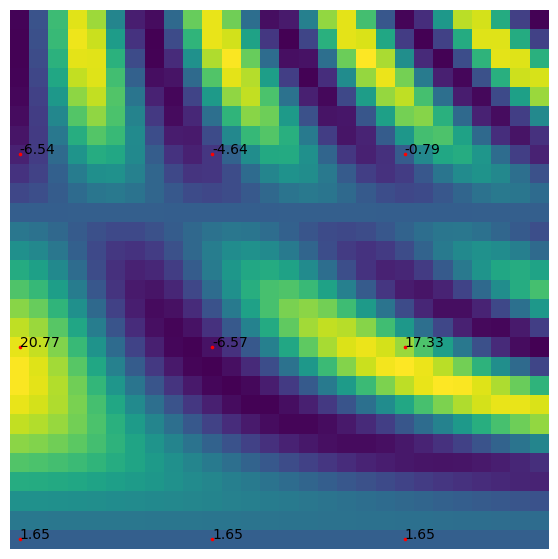

In [13]:
plot_annotated_images(grid_pins, grid_labels)

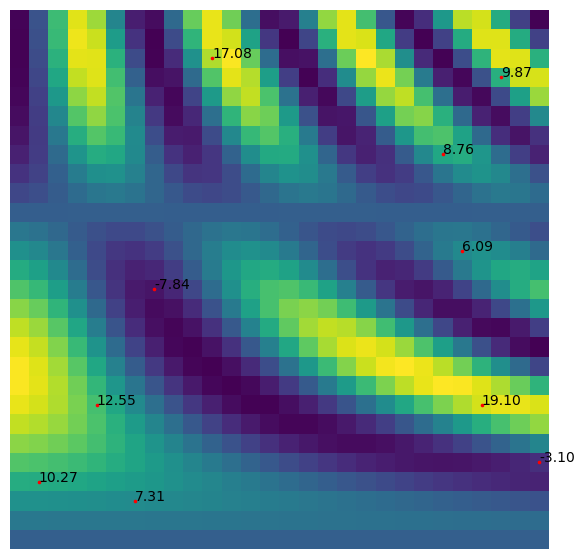

In [14]:
plot_annotated_images(rand_pins, rand_labels)

In [15]:
def extract_with_ddpm(data, n_steps, store_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load DDPM Model
    ddpm = DDPM(UNet(input_channels=4), n_steps=n_steps, device=device)
    ddpm.load_state_dict(torch.load(store_path, map_location=device))
    
    # Move input to the same device as the model
    x0 = data.unsqueeze(0).to(device)
    n = len(x0)

    # Picking some noise for each of the images in the batch, a timestep, and the respective alpha_bars
    eta = torch.randn_like(x0.float()).to(device)
    t = torch.randint(0, n_steps, (n,)).to(device)

    # Computing the noisy image based on x0 and the time-step (forward process)
    # print(x0.shape)
    noisy_imgs = ddpm(x0, t, eta)

    # Getting model estimation of noise based on the images and the time-step
    eta_theta, concatenated_feature_map = ddpm.backward(noisy_imgs, t.reshape(n, -1))

    return concatenated_feature_map

In [16]:
ddpm_folder = "Synthetic_ddpm"
n_steps = 1000
store_path = f"./history/ddpm_model_Synthetic.pt"

ddpm_root_folder = f"./data/{ddpm_folder}/{d1}by{d2}pixels_{n}images_{seed}seed"   
ddpm_image_folder = f"./data/{ddpm_folder}/{d1}by{d2}pixels_{n}images_{seed}seed/images"

del_and_create(ddpm_root_folder)
os.makedirs(ddpm_image_folder)

In [17]:
ddpm_images = []

for i in range(n):
    img_name = f"{i}.png"    
    image = read_image(f'{image_folder}/{img_name}')
    image = transforms.functional.resize(image, size=(28, 28))
    
    ddpm_image = extract_with_ddpm(image, n_steps, store_path)
    ddpm_image = ddpm_image.squeeze()

    ddpm_images.append(ddpm_image)

In [18]:
random_data_folder = f"./data/{ddpm_folder}/{d1}by{d2}pixels_{n}images_{seed}seed/random_{L}pins/"
mesh_data_folder = f"./data/{ddpm_folder}/{d1}by{d2}pixels_{n}images_{seed}seed/mesh_{step}step_pins/"

del_and_create(random_data_folder)
del_and_create(mesh_data_folder)

In [19]:
save_data(ddpm_images, rand_pins, rand_labels, f"{ddpm_root_folder}/", random_data_folder, mode='ddpm')
save_data(ddpm_images, grid_pins, grid_labels, f"{ddpm_root_folder}/", mesh_data_folder, mode='ddpm')

Data and images have been saved to the CSV and image files.
Data and images have been saved to the CSV and image files.


In [20]:
L = 100
step = 3

random_data_folder = f"./data/{folder}/{d1}by{d2}pixels_{n}images_{seed}seed/random_{L}pins/"
mesh_data_folder = f"./data/{folder}/{d1}by{d2}pixels_{n}images_{seed}seed/mesh_{step}step_pins/"

del_and_create(random_data_folder)
del_and_create(mesh_data_folder)

add_header(random_data_folder, header)
add_header(mesh_data_folder, header)

rand_pins = []
grid_pins = []
rand_labels = []
grid_labels = []

for i in range(n):

    # Generate a list of all possible (x, y) coordinates
    rand_p_1i = np.arange(0, d1, 1).reshape(-1, 1)
    rand_p_2i = np.arange(0, d2, 1).reshape(-1, 1)
    all_possible_pins = [(x.tolist(), y.tolist()) for x in rand_p_1i for y in rand_p_2i] # coordinates of the pins

    # Shuffle the list to randomize the order
    random.shuffle(all_possible_pins)

    # Select the first n coordinates to ensure uniqueness
    rand_p_i = all_possible_pins[:L]

    grid_p_1i = np.arange(0, d1, step).reshape(-1, 1)
    grid_p_2i = np.arange(0, d2, step).reshape(-1, 1)
    grid_p_i = [(x.tolist(), y.tolist()) for x in grid_p_1i for y in grid_p_2i] # coordinates of the pins
    grid_p_i = np.random.permutation(grid_p_i)
    
    rand_y_i = find_labels(rand_p_i)
    grid_y_i = find_labels(grid_p_i)

    rand_pins.append(reformat(rand_p_i))
    grid_pins.append(reformat(grid_p_i))
    rand_labels.append(rand_y_i.tolist())
    grid_labels.append(grid_y_i.tolist())
    
save_data(images, rand_pins, rand_labels, f"{root_folder}/", random_data_folder, mode='ae')
save_data(images, grid_pins, grid_labels, f"{root_folder}/", mesh_data_folder, mode='ae')

Data and images have been saved to the CSV and image files.
Data and images have been saved to the CSV and image files.


In [21]:
random_data_folder = f"./data/{ddpm_folder}/{d1}by{d2}pixels_{n}images_{seed}seed/random_{L}pins/"
mesh_data_folder = f"./data/{ddpm_folder}/{d1}by{d2}pixels_{n}images_{seed}seed/mesh_{step}step_pins/"

del_and_create(random_data_folder)
del_and_create(mesh_data_folder)

In [22]:
save_data(ddpm_images, rand_pins, rand_labels, f"{ddpm_root_folder}/", random_data_folder, mode='ddpm')
save_data(ddpm_images, grid_pins, grid_labels, f"{ddpm_root_folder}/", mesh_data_folder, mode='ddpm')

Data and images have been saved to the CSV and image files.
Data and images have been saved to the CSV and image files.
